In [1]:
import torch
from torchtext.legacy import data
import tqdm

In [2]:
from emoji import demojize
from nltk.tokenize import TweetTokenizer


tokenizer = TweetTokenizer()


def normalizeToken(token):
    lowercased_token = token.lower()
    if token.startswith("@"):
        return "@USER"
    elif lowercased_token.startswith("http") or lowercased_token.startswith("www"):
        return "HTTPURL"
    elif len(token) == 1:
        return demojize(token)
    else:
        if token == "’":
            return "'"
        elif token == "…":
            return "..."
        else:
            return token


def normalizeTweet(tweet):
    tokens = tokenizer.tokenize(tweet.replace("’", "'").replace("…", "..."))
    normTweet = " ".join([normalizeToken(token) for token in tokens])

    normTweet = (
        normTweet.replace("cannot ", "can not ")
        .replace("n't ", " n't ")
        .replace("n 't ", " n't ")
        .replace("ca n't", "can't")
        .replace("ai n't", "ain't")
    )
    normTweet = (
        normTweet.replace("'m ", " 'm ")
        .replace("'re ", " 're ")
        .replace("'s ", " 's ")
        .replace("'ll ", " 'll ")
        .replace("'d ", " 'd ")
        .replace("'ve ", " 've ")
    )
    normTweet = (
        normTweet.replace(" p . m .", "  p.m.")
        .replace(" p . m ", " p.m ")
        .replace(" a . m .", " a.m.")
        .replace(" a . m ", " a.m ")
    )

    return normTweet.split(" ")

In [3]:
SEED = 42

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize = normalizeTweet, include_lengths = True)

LABEL = data.LabelField(dtype = torch.float)

In [4]:
dataset = data.TabularDataset(path='cresci-sampled.csv',format='csv',
                            skip_header=True,
                            fields=[('tweet',TEXT), ('label',LABEL)])

In [5]:
import random
train_data, valid_data = dataset.split(split_ratio=0.9, random_state = random.seed(SEED))

In [6]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')

Number of training examples: 1735572
Number of validation examples: 192841


In [7]:
valid_data, test_data = valid_data.split(split_ratio=0.5,random_state = random.seed(SEED))

In [8]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 1735572
Number of validation examples: 96420
Number of testing examples: 96421


In [9]:
#MAX_VOCAB_SIZE = 20_000

TEXT.build_vocab(train_data, 
                 min_freq = 5,
                 #max_size = MAX_VOCAB_SIZE,
                 vectors = "glove.twitter.27B.200d",
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

In [10]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

Unique tokens in TEXT vocabulary: 105329
Unique tokens in LABEL vocabulary: 2


In [11]:
print(TEXT.vocab.freqs.most_common(30))

[('.', 996667), ('@USER', 743664), (',', 563826), ('HTTPURL', 426639), (':', 403397), ('-', 402786), ('the', 387372), ('!', 366903), ('a', 344324), ('"', 336257), ('to', 307316), ('I', 302606), ('RT', 248349), ('?', 240784), ('you', 210006), ('of', 208740), ('in', 206461), ('is', 197808), ('and', 170712), ('\x80', 157298), ('che', 155708), ('di', 154508), ('¨', 144074), ('for', 121055), ('it', 120818), ("'s", 119705), ('...', 118018), ('Ã', 117123), ('ã', 108741), ('non', 106995)]


In [12]:
print(TEXT.vocab.itos[:100])

['<unk>', '<pad>', '.', '@USER', ',', 'HTTPURL', ':', '-', 'the', '!', 'a', '"', 'to', 'I', 'RT', '?', 'you', 'of', 'in', 'is', 'and', '\x80', 'che', 'di', '¨', 'for', 'it', "'s", '...', 'Ã', 'ã', 'non', 'la', 'â', 'e', 'that', 'il', 'un', '\x81', 'on', 'my', 'me', "'", "n't", 'Ù', 'Ø', 'The', 'your', 'do', 'i', 'be', 'are', 'à', 'with', 'per', '¤', 'have', 'not', 'this', 'Ð', 'una', '¦', 'le', 'si', '¹', 'so', 'at', 'A', ')', 'like', 'but', 'out', '\x82', "'m", 'what', '\x9c', 'can', 'was', 'just', ':copyright:', 'get', 'con', 'sono', 'all', '&', 'mi', 'se', 'about', '²', '\x99', 'one', '§', 'we', 'when', 'Read', 'come', '\x9d', 'You', 'as', 'they']


In [13]:
print(vars(train_data.examples[5000]))

{'tweet': ['Tips', 'To', 'Draw', 'More', 'Traffic', 'With', 'Quality', 'Link', 'Building', 'HTTPURL'], 'label': '1'}


In [14]:
BATCH_SIZE = 512

#placing the tensors on the GPU if one is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    shuffle = True,
    sort_key = lambda x: len(x.tweet),
    device = device)

In [15]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, tweet, tweet_lengths):
        
        #tweet = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(tweet))
        
        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        # lengths need to be on CPU!
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, tweet_lengths.to('cpu'))
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        #output = [sent len, batch size, hid dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:],hidden[-1,:,:]), dim = 1))
                
        #hidden = [batch size, hid dim * num directions]
            
        return self.fc(hidden)

In [16]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 200
HIDDEN_DIM = 200
OUTPUT_DIM = 1
N_LAYERS = 3
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = RNN(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)

In [17]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 23,635,801 trainable parameters


In [18]:
for n, p in model.named_parameters():
    print(f'name: {n}, shape: {p.shape}')

name: embedding.weight, shape: torch.Size([105329, 200])
name: rnn.weight_ih_l0, shape: torch.Size([800, 200])
name: rnn.weight_hh_l0, shape: torch.Size([800, 200])
name: rnn.bias_ih_l0, shape: torch.Size([800])
name: rnn.bias_hh_l0, shape: torch.Size([800])
name: rnn.weight_ih_l0_reverse, shape: torch.Size([800, 200])
name: rnn.weight_hh_l0_reverse, shape: torch.Size([800, 200])
name: rnn.bias_ih_l0_reverse, shape: torch.Size([800])
name: rnn.bias_hh_l0_reverse, shape: torch.Size([800])
name: rnn.weight_ih_l1, shape: torch.Size([800, 400])
name: rnn.weight_hh_l1, shape: torch.Size([800, 200])
name: rnn.bias_ih_l1, shape: torch.Size([800])
name: rnn.bias_hh_l1, shape: torch.Size([800])
name: rnn.weight_ih_l1_reverse, shape: torch.Size([800, 400])
name: rnn.weight_hh_l1_reverse, shape: torch.Size([800, 200])
name: rnn.bias_ih_l1_reverse, shape: torch.Size([800])
name: rnn.bias_hh_l1_reverse, shape: torch.Size([800])
name: rnn.weight_ih_l2, shape: torch.Size([800, 400])
name: rnn.weight_

In [19]:
def initialize_parameters(m):
    if isinstance(m, nn.Embedding):
        nn.init.uniform_(m.weight, -0.05, 0.05)
    elif isinstance(m, nn.LSTM):
        for n, p in m.named_parameters():
            if 'weight_ih' in n:
                i, f, g, o = p.chunk(4)
                nn.init.xavier_uniform_(i)
                nn.init.xavier_uniform_(f)
                nn.init.xavier_uniform_(g)
                nn.init.xavier_uniform_(o)
            elif 'weight_hh' in n:
                i, f, g, o = p.chunk(4)
                nn.init.orthogonal_(i)
                nn.init.orthogonal_(f)
                nn.init.orthogonal_(g)
                nn.init.orthogonal_(o)
            elif 'bias' in n:
                i, f, g, o = p.chunk(4)
                nn.init.zeros_(i)
                nn.init.ones_(f)
                nn.init.zeros_(g)
                nn.init.zeros_(o)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

In [20]:
model.apply(initialize_parameters)

RNN(
  (embedding): Embedding(105329, 200, padding_idx=1)
  (rnn): LSTM(200, 200, num_layers=3, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=400, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [21]:
pretrained_embeddings = TEXT.vocab.vectors

#[vocab size, embedding dim]
print(pretrained_embeddings.shape)

torch.Size([105329, 200])


In [22]:
#replace the initial weights of the embedding layer with the pre-trained embeddings

model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[ 1.9269e+00,  1.4873e+00,  9.0072e-01,  ...,  6.3188e-01,
          3.1253e-01, -3.3502e-02],
        [ 1.3032e+00,  4.8787e-01,  1.1340e+00,  ..., -6.2644e-01,
         -5.1509e-01,  6.9029e-01],
        [ 3.5132e-01,  5.6084e-04, -2.1488e-01,  ...,  3.6684e-02,
         -3.7206e-02,  8.5384e-01],
        ...,
        [-1.5163e+00,  2.7271e-01, -8.6883e-01,  ..., -9.3904e-01,
         -1.3688e+00, -4.6220e-01],
        [-1.2587e+00,  3.5036e-01,  4.9768e-01,  ..., -1.0621e+00,
          2.8939e-01, -5.0899e-01],
        [-1.5821e+00, -1.0924e+00,  9.2017e-01,  ..., -3.8838e-01,
         -2.4814e+00, -3.6030e-01]])

In [23]:
#Manually setting <unk> and <pad> row in embedding weight matrix to zeros.

UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 3.5132e-01,  5.6084e-04, -2.1488e-01,  ...,  3.6684e-02,
         -3.7206e-02,  8.5384e-01],
        ...,
        [-1.5163e+00,  2.7271e-01, -8.6883e-01,  ..., -9.3904e-01,
         -1.3688e+00, -4.6220e-01],
        [-1.2587e+00,  3.5036e-01,  4.9768e-01,  ..., -1.0621e+00,
          2.8939e-01, -5.0899e-01],
        [-1.5821e+00, -1.0924e+00,  9.2017e-01,  ..., -3.8838e-01,
         -2.4814e+00, -3.6030e-01]])


In [24]:
#import torch.optim as optim
import torch_optimizer as optim
#from transformers import AdamW, get_linear_schedule_with_warmup

N_EPOCHS = 100
#total_steps = len(train_iterator) * N_EPOCHS

model = model.to(device)

optimizer = optim.MADGRAD(model.parameters(),lr=2e-3,                          
                        momentum=0.9,
                        weight_decay=0,
                        eps=1e-6
)

criterion = nn.BCEWithLogitsLoss()
criterion = criterion.to(device)

#scheduler = get_linear_schedule_with_warmup(
#  optimizer,
#  num_warmup_steps=0,
#  num_training_steps=total_steps
#)

In [25]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [26]:
import tqdm
import sys

def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in tqdm.tqdm(iterator, desc='training...', file=sys.stdout):
        
        optimizer.zero_grad()
        
        tweet, tweet_lengths = batch.tweet
        
        predictions = model(tweet, tweet_lengths).squeeze()
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [27]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in tqdm.tqdm(iterator, desc='evaluating...', file=sys.stdout):

            tweet, tweet_lengths = batch.tweet
            
            predictions = model(tweet, tweet_lengths).squeeze()
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [28]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [29]:
#FREEZE_FOR = 5

best_valid_loss = float('inf')
train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

model.embedding.weight.requires_grad = unfrozen = False

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        stop = 0
        torch.save(model.state_dict(), 'LSTM-Cresci_GloVe.pt')
    else:
        model.embedding.weight.requires_grad = unfrozen = True
        stop +=1
        print("Counter {} of 5".format(stop))
        
        if stop > 4:
            print(f'Early stopping with best valid loss: {best_valid_loss:.3f} | Valid Loss this Epoch: {valid_loss:.3f} . . .' )
            break

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s) | Frozen? {not unfrozen}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

evaluating...: 100%|██████████| 189/189 [00:01<00:00, 151.12it/s]
Epoch: 01 | Epoch Time: 0m 54s) | Frozen? True
	Train Loss: 0.196 | Train Acc: 92.13%
	 Val. Loss: 0.166 |  Val. Acc: 93.37%
evaluating...: 100%|██████████| 189/189 [00:01<00:00, 149.22it/s]
Epoch: 02 | Epoch Time: 0m 52s) | Frozen? True
	Train Loss: 0.148 | Train Acc: 94.56%
	 Val. Loss: 0.133 |  Val. Acc: 95.10%
evaluating...: 100%|██████████| 189/189 [00:01<00:00, 152.21it/s]
Epoch: 03 | Epoch Time: 0m 54s) | Frozen? True
	Train Loss: 0.136 | Train Acc: 95.05%
	 Val. Loss: 0.123 |  Val. Acc: 95.55%
evaluating...: 100%|██████████| 189/189 [00:01<00:00, 152.47it/s]
Epoch: 04 | Epoch Time: 0m 54s) | Frozen? True
	Train Loss: 0.129 | Train Acc: 95.32%
	 Val. Loss: 0.117 |  Val. Acc: 95.69%
evaluating...: 100%|██████████| 189/189 [00:01<00:00, 153.37it/s]
Epoch: 05 | Epoch Time: 0m 55s) | Frozen? True
	Train Loss: 0.125 | Train Acc: 95.48%
	 Val. Loss: 0.114 |  Val. Acc: 95.85%
evaluating...: 100%|██████████| 189/189 [00:0

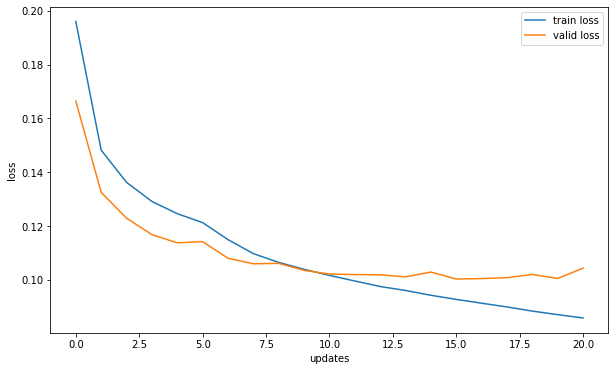

In [30]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(train_losses, label='train loss')
ax.plot(valid_losses, label='valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss');

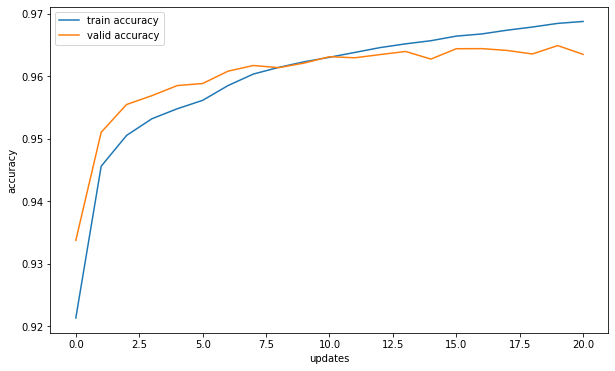

In [31]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(train_accs, label='train accuracy')
ax.plot(valid_accs, label='valid accuracy')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('accuracy');

In [29]:
model.load_state_dict(torch.load('LSTM-Cresci_GloVe.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

evaluating...: 100%|██████████| 189/189 [00:02<00:00, 74.96it/s] 
Test Loss: 0.100 | Test Acc: 96.40%


In [30]:
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

def get_predictions(model, test_iterator):
    model.eval()
    
    tweet_texts = []
    predictions = []
    prediction_probs = []
    real_values = []
    
    with torch.no_grad():
         for batch in test_iterator:
            tweet, tweet_lengths = batch.tweet
            labels = batch.label
            outputs = model(tweet, tweet_lengths).squeeze()

            preds = torch.round(torch.sigmoid(outputs))
            probs = torch.sigmoid(outputs)

            tweet_texts.extend(tweet)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(labels)
            
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return tweet_texts, predictions, prediction_probs, real_values

In [31]:
y_tweet_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_iterator
)

In [52]:
class_names = ['Human', 'Bot']
print(classification_report(y_test, y_pred, digits=4, labels=(0,1), target_names=class_names))

              precision    recall  f1-score   support

         0.0     0.9687    0.9633    0.9660     51091
         1.0     0.9589    0.9649    0.9619     45330

    accuracy                         0.9641     96421
   macro avg     0.9638    0.9641    0.9640     96421
weighted avg     0.9641    0.9641    0.9641     96421



In [47]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

         0.0     0.9687    0.9633    0.9660     51091
         1.0     0.9589    0.9649    0.9619     45330

    accuracy                         0.9641     96421
   macro avg     0.9638    0.9641    0.9640     96421
weighted avg     0.9641    0.9641    0.9641     96421



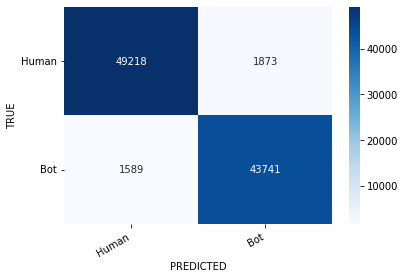

In [32]:
import matplotlib.pyplot as plt
import pandas as pd

class_names = ['Human', 'Bot']

def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('TRUE')
  plt.xlabel('PREDICTED');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [37]:
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(y_test, y_pred)

0.9279742987833405

AUC Score
0.964142937395464


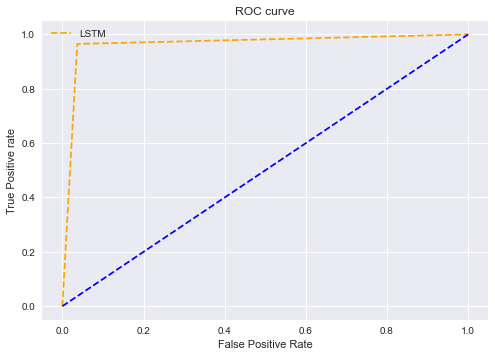

In [38]:
    plt.style.use('seaborn')

    fpr1, tpr1, thresh1 = roc_curve(y_test, y_pred, pos_label=1)

    random_probs = [0 for i in range(len(y_test))]
    p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)
    auc_score = roc_auc_score(y_test, y_pred)
    print('AUC Score')
    print(auc_score)
    
    # plot roc curves
    plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='LSTM')
    plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
    # title
    plt.title('ROC curve')
    # x label
    plt.xlabel('False Positive Rate')
    # y label
    plt.ylabel('True Positive rate')

    plt.legend(loc='best')
    plt.savefig('ROC',dpi=300)
    plt.show();